# Планирование бюджета маркетологов Яндекс.Афиши

Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.
Вам предстоит изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.
Выручка измеряется в условных единицах — у.е.

---

**Цель проекта** - изучение данных о продажах на сайте Яндекс.Афиши и затратах на различные источники трафика. На основе исследования маркетологи заказчика смогут перераспределить бюджет для улучшения финансовых показателей.

Массивы данных содержит в себе информацию о посещениях сайта (дата и время начала и конца пользовательской сессии, источник трафика, тип устройства), заказах за рассматриваемый период (выручка и время совершения покупки), а также о рекламных расходах (стоимость затрат и дат, в которые они состоялись).   

В ходе исследования решается ряд **задач**:
- подготовка данных; 
- проведение анализа информации:
    + расчет продуктовых метрик (количество пользователей, продолжительность сессий, коэффициент удержания);
    + расчет метрик электронной коммерции (среднее время до покупки, среднее количество покупок на клиента, средняя выручка, LTV);
    + расчет маркетинговых метрик (CAC, ROMI и др.);
- построение выводов и рекомендаций.
    
В работе используется метод когортного анализа.    

## Содержание

[Изучение общей информации](#review)
- [Загрузка датафреймов](#loading)
- [Подготовка данных](#preparation)

[Расчет метрик и анализ данных](#metrics)

- [Продуктовые метрики](#prod_met)
    - [Количество уникальных пользователей](#user_unique)
    - [Количество посещений сайта](#visits_num)
    - [Количество и средняя продолжительность пользовательских сессий](#sessions)
    - [Расчет Retention Rate](#ret_rate)
- [Метрики электронной коммерции](#ecom_met)
    - [Среднее время до совершения покупки](#time_to_buy)
    - [Среднее количество покупок на клиента за полгода](#buy_per_user)
    - [Средняя выручка с пользователя](#avg_rev)
    - [Динамика LTV](#ltv)
- [Маркетинговые метрики](#mark_met)
    - [Расходы на маркетинг в динамике и разрезе источников](#mark_costs)
    - [Стоимость привлечения покупателя. CAC](#cac)
    - [Окупаемость в разрезе источников. ROMI](#romi)
- [Анализ в разрезе типов устройств](#device)    
    

[Выводы и рекомендации](#conclusion)
    

## Шаг 1. Изучение общей информации <a name="review"></a>

Импорт библиотек, которые потребуются для выполнения исследования:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**Загрузка датафреймов** <a name="loading"></a>

Считывание файлов с данными в датафреймы:

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Получение данных о первых 10 строках таблицы **visits**:

In [3]:
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Общая информация о данных таблицы **visits**:

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


В таблице **visits** представлена информация о посещениях сайта. В ней 5 столбцов: 

- **Device** - тип устройства / строковый тип данных
- **End Ts** - дата и время конца пользовательской сессии / строковый тип данных
- **Source Id** - идентификатор источника трафика / целочисл. тип данных
- **Start Ts** - дата и время начала пользовательской сессии / строковый тип данных
- **Uid** - идентификатор пользователя / целочисл. тип данных с неотрицательными значениями

Общее количество записей о посещениях сайта - 359400. Пропусков нет.

---

Получение данных о первых 10 строках таблицы **orders**:

In [5]:
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Общая информация о данных таблицы **orders**:

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


В таблице **orders** представлена информация о всех заказах за рассматриваемый период. В ней 3 столбца: 

- **Buy Ts** - время совершения заказа / строковый тип данных
- **Revenue** - выручка от заказа / числа с плав. точкой
- **Uid** - идентификатор пользователя / целочисл. тип данных с неотрицательными значениями

Общее количество записей о заказах - 50415. Пропусков нет.

---

Получение данных о первых 10 строках таблицы **costs**:

In [7]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


Общая информация о данных таблицы **costs**:

In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В таблице **costs** представлена статистика рекламных расходов. В ней также 3 столбца: 

- **source_id** - идентификатор источника трафика / целочисл. тип данных
- **dt** - дата совершения расходов / строковый тип данных
- **costs** - стоимость расходов / числа с плав. точкой

Общее количество записей о рекламных затратах - 2542. Пропусков нет.

Таким образом, таблица **visits** содержит информацию о посещениях сайта - идентификатор пользователя, дата и время начала и конца пользовательской сессии, идентификатор источника, а также тип устройства.

В таблице **orders** находится информация о всех заказах за рассматриваемый период - идентификатор пользователя, выручка и время совершения.

Таблица **costs** состоит из записей о рекламных расходах - идентификаторах источников, стоимости затрат, а также дат, в которые они состоялись.

Задачи, которые необходимо решить, прежде чем приступить к расчету метрик:

- переименование столбцов в соответствии с общепринятыми стандартами;
- изменение типов данных в столбцах.

**Подготовка данных** <a name="preparation"></a>

Рассмотрим отдельно столбцы каждой таблицы на предмет наличия ошибок в данных, а также приведем их к нужным типам там, где это необходимо. 

#### **Таблица visits**

Переименуем столбцы:

In [9]:
visits.columns = visits.columns.str.lower()
visits.columns = visits.columns.str.replace(" ", "_")

In [10]:
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Теперь рассмотрим поочередно все столбцы:

In [11]:
visits['device'].describe()

count      359400
unique          2
top       desktop
freq       262567
Name: device, dtype: object

Переменная **device** принимает только два значения - desktop и touch, соответствующие настольным компьютерам либо мобильным устройствам/планшетам.

В следующем столбце (**end_ts**) поменяем тип данных со строкового на даты:

In [12]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [13]:
visits['end_ts'].describe()

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object

Рассматриваемый период - год (с 01.06.2017 по 01.06.2018).

Рассмотрим статистику по источникам трафика **source_id**:

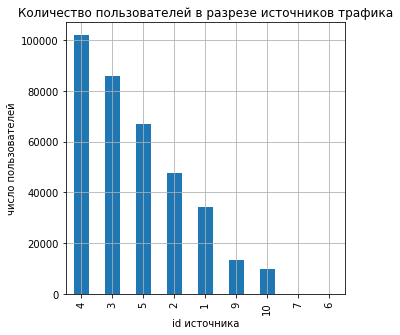

In [14]:
visits.pivot_table(index = 'source_id', values = 'uid', aggfunc = 'count')\
                            .reset_index().sort_values(by = 'uid', ascending = False)\
                            .plot(x = 'source_id', y = 'uid', grid = True, figsize = (5,5),\
                             title = 'Количество пользователей в разрезе источников трафика', kind = 'bar', legend = False)
plt.xlabel('id источника')
plt.ylabel('число пользователей')
plt.show()

Обратим внимание на то, что либо записи об источнике с id = 8 пропущены, либо этот источник не привлек ни одного посетителя на сайт. В любом случае, восстановить эти данные в моменте не представляется возможным (надо передать информацию маркетологам).

В столбце **start_ts** также поменяем тип со строкового на даты:

In [15]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [16]:
visits['start_ts'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

Рассматриваемый период - тоже год (с 01.06.2017 по 31.05.2018), при этом и самая ранняя, и самая поздняя даты меньше соответственно самой ранней и самой поздней даты столбца **end_ts**, как и ожидается.

Столбец **uid** отдельно рассматривать на аномалии не имеет смысла, т.к. это всего лишь большие неотрицательные числа.

In [17]:
visits['uid'].head()

0    16879256277535980062
1      104060357244891740
2     7459035603376831527
3    16174680259334210214
4     9969694820036681168
Name: uid, dtype: uint64

In [18]:
visits['uid'].nunique()

228169

Количество уникальных пользователей, заходивших на сайт, составляет 228169 человек.

#### **Таблица orders**

Переименуем столбцы:

In [19]:
orders.columns = orders.columns.str.lower()
orders.columns = orders.columns.str.replace(" ", "_")

In [20]:
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

В столбце **buy_ts** поменяем тип со строкового на даты:

In [21]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [22]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Период заказов совпадает с периодом посещений сайта из таблицы **visits**.

Рассмотрим показатель выручки с заказа **revenue**:

In [23]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Средняя стоимость заказа составляет 5 у.е., причем медианное значение всего 2,5 у.е., а 75%-й квартиль - 4,89 у.е. Такое расхождение объясняется несколькими заказами на аномально большие суммы, максимальный из которых составляет 2633 у.е. В частности, заказов на сумму более 500 у.е. имеется 13 шт. Нельзя однозначно сказать, что это ошибка в данных. Возможно, кто-то покупал сразу несколько дорогостоящих билетов.

In [24]:
orders.query('revenue >= 500').shape[0]

13

Также обратим внимание на то, что минимальная выручка от заказа составляет 0 у.е.

In [25]:
orders.query('revenue == 0').shape[0]

51

Таких записей в базе 51. Возможно, выручка Яндекс.Афиши составила 0 р, если покупатель использовал промокод или подарочный сертификат. Не будем исключать указанные строки из датафрейма. 

Опять же, столбец **uid** рассматривать на аномалии не имеет смысла.

In [26]:
orders['uid'].head()

0    10329302124590727494
1    11627257723692907447
2    17903680561304213844
3    16109239769442553005
4    14200605875248379450
Name: uid, dtype: uint64

In [27]:
orders['uid'].nunique()

36523

Количество уникальных пользователей, совершивших заказ, составляет 36523 человека.

#### **Таблица costs**

Переменные названы корректно, менять их не требуется.

Рассмотрим статистику по расходам в зависимости от источника трафика **source_id**:

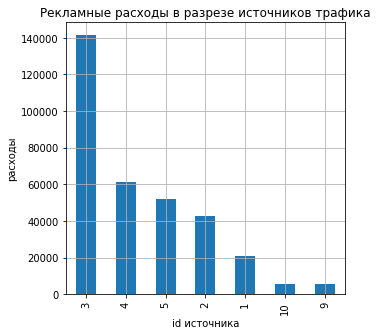

In [28]:
costs.pivot_table(index = 'source_id', values = 'costs', aggfunc = 'sum')\
                            .reset_index().sort_values(by = 'costs', ascending = False)\
                            .plot(x = 'source_id', y = 'costs', grid = True, figsize = (5,5),\
                             title = 'Рекламные расходы в разрезе источников трафика', kind = 'bar', legend = False)
plt.xlabel('id источника')
plt.ylabel('расходы')
plt.show()

Обратим внимание на то, что либо записи об источниках с id = 6, 7 и 8 пропущены, либо по указанным источникам не было затрат. Первый вариант представляется более вероятным, однако данные нет возможности восстановить.

В столбце **dt** изменим тип данных со строкового на даты:

In [29]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [30]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Рассматриваемый период совпадает с периодом по двум другим таблицам (01.06.2017-01.06.2018).

Наконец, рассмотрим сами затраты **costs**:

In [31]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

Средняя величина расходов составляет 129,5 у.е., медианное значение - 77,29 у.е. Минимальные затраты - 0,54 у.е., максимальные - 1788,3 у.е.

**Вывод**

Таблица **visits** содержит информацию о посещениях сайта - идентификатор пользователя, дата и время начала и конца пользовательской сессии, идентификатор источника, а также тип устройства.

В таблице **orders** находится информация о всех заказах за рассматриваемый период - идентификатор пользователя, выручка и время совершения.

Таблица **costs** состоит из записей о рекламных расходах - идентификаторах источников, стоимости затрат, а также дат, в которые они состоялись.

Столбцы таблиц **visits** и **orders** были переименованы в соответствии с общепринятыми стандартами.

Пропусков в таблицах не обнаружено. При этом, возможно, в таблице **visits** полностью отсутствуют данные об источнике трафика с id = 8 (если он в принципе существовал), а в таблице **costs** - об источниках трафика с id = 6, 7 или 8, однако восстановить эту информацию на данном этапе не представляется возможным.

Изменен тип данных во всех столбцах с датами (**end_ts**, **start_ts**, **buy_ts**, **dt**).

Данные готовы к анализу.


## Шаг 2. Расчет метрик и анализ данных <a name="metrics"></a>

### Продуктовые метрики <a name="prod_met"></a>

Рассчитаем основные продуктовые метрики, отражающие пользовательскую активность на сайте.

**Количество уникальных пользователей** <a name="user_unique"></a>

- **DAU** — количество уникальных пользователей в день;
- **WAU** — количество уникальных пользователей в неделю;
- **MAU** — количество уникальных пользователей в месяц.

Выделим в отдельные столбцы год, месяц и неделю, а также полную дату:

In [32]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_weekday'] = visits['start_ts'].dt.weekday
visits['session_date'] = visits['start_ts'].dt.date
display(visits.head()) 

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_weekday,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,0,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,5,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,6,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2,2017-12-27


Сгруппируем данные по уникальным пользователям и найдём среднее:

In [33]:
dau = visits.groupby('session_date').agg({'uid': 'nunique'}).reset_index()
wau = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).reset_index()
mau = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).reset_index()

dau_total = dau.mean()
wau_total = wau['uid'].mean()
mau_total = mau['uid'].mean()

print('Среднее значение DAU =', int(dau_total)) 
print('Среднее значение WAU =', int(wau_total))
print('Среднее значение MAU =', int(mau_total))

Среднее значение DAU = 907
Среднее значение WAU = 5716
Среднее значение MAU = 23228


Построим графики изменения метрик во времени.

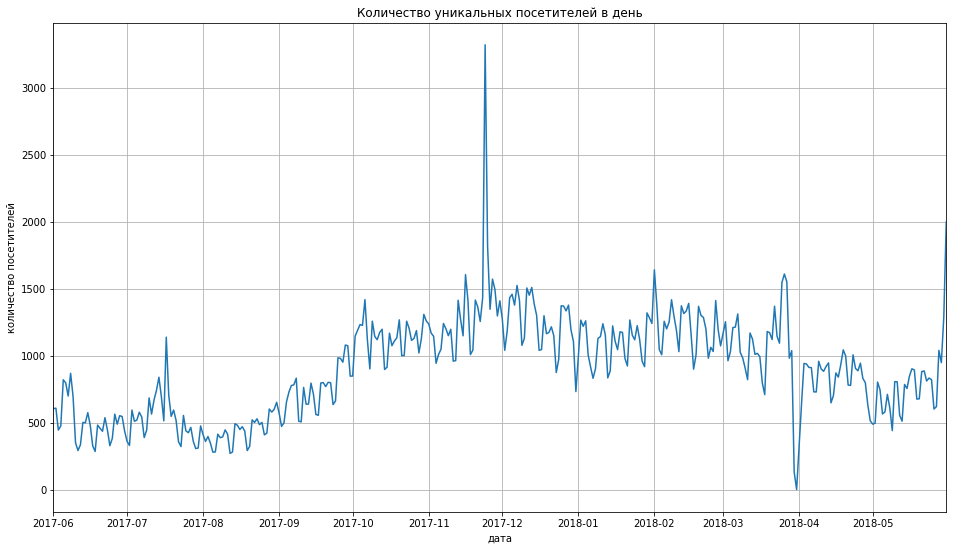

In [34]:
dau.plot(x = 'session_date', y = 'uid', grid = True, figsize = (16,9),\
                         title = 'Количество уникальных посетителей в день', legend = False)
plt.xlabel('дата')
plt.ylabel('количество посетителей')
plt.show()

График носит пилообразный характер, причем в каждом месяце содержится примерно по 4 зубца, что может соответствовать определенному дню недели. Вероятно, посещаемость сайта отличается на буднях и выходных. 

In [35]:
weekday_m = visits.groupby('session_weekday').agg({'uid': 'nunique'}).reset_index()
weekday_m

,session_weekday,uid
0,0,45207
1,1,44019
2,2,43154
3,3,47190
4,4,44200
5,5,35110
6,6,34418


Таким образом, в течение рассматриваемого периода на субботы и воскресенья в целом приходилось на 20-25% посещений меньше, чем в остальные дни. Локальные экстремумы на графике DAU соответствуют выходным. 

На графике DAU заметен тренд роста числа уникальных посетителей с августа по декабрь 2017 г. Затем до марта 2018 г. количество уникальных посетителей держится примерно на одном уровне, с марта по май 2018 г. снижается и снова резко вырастает к концу рассматриваемого временного промежутка. Отдельно стоит отметить два события: ожидаемый высокий пик накануне новогодних праздников, а также спад до нулевого значения в конце марта 2018 г. (возможно, сайт просто не функционировал в тот день).

---

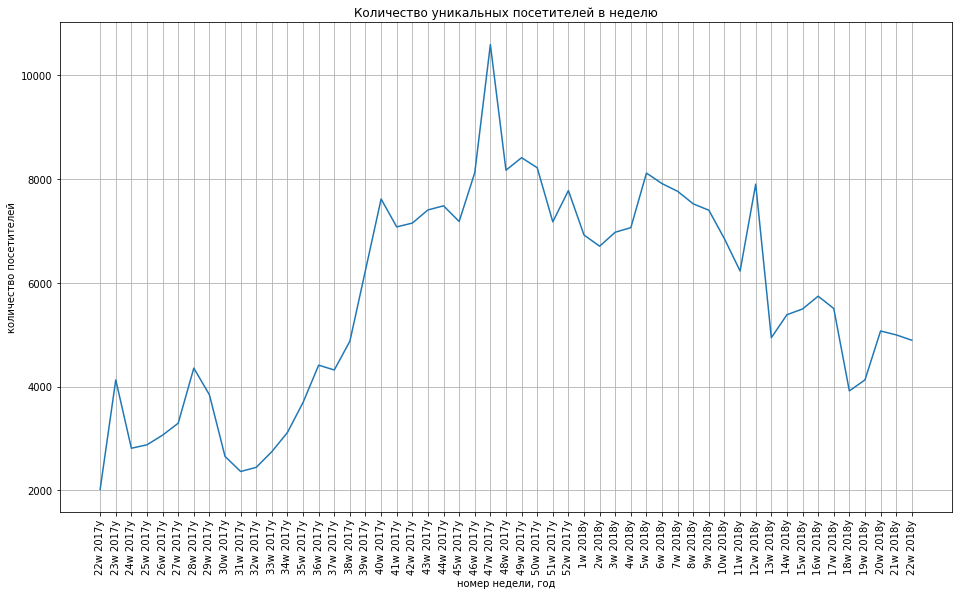

In [36]:
x = ['{0}w {1}y'.format(week, year) for week, year in zip(wau['session_week'], wau['session_year'])]
y = wau['uid']
plt.figure(figsize=(16,9))
plt.plot(x, y)
plt.title('Количество уникальных посетителей в неделю')
plt.xlabel('номер недели, год')
plt.xticks(rotation=90)
plt.ylabel('количество посетителей')
plt.grid()
plt.show()

Поведение графика WAU в целом напоминает DAU, однако на нем отсутствуют локальные пики, соответствующие будням и выходным. Кривая выглядит более крутой, поскольку на ней нет аномальных значений, приводящих к изменению масштаба. Прослеживаются те же тренды: рост с августа по декабрь 2017 г., стагнация до марта 2018 г. и дальнейшее падение.

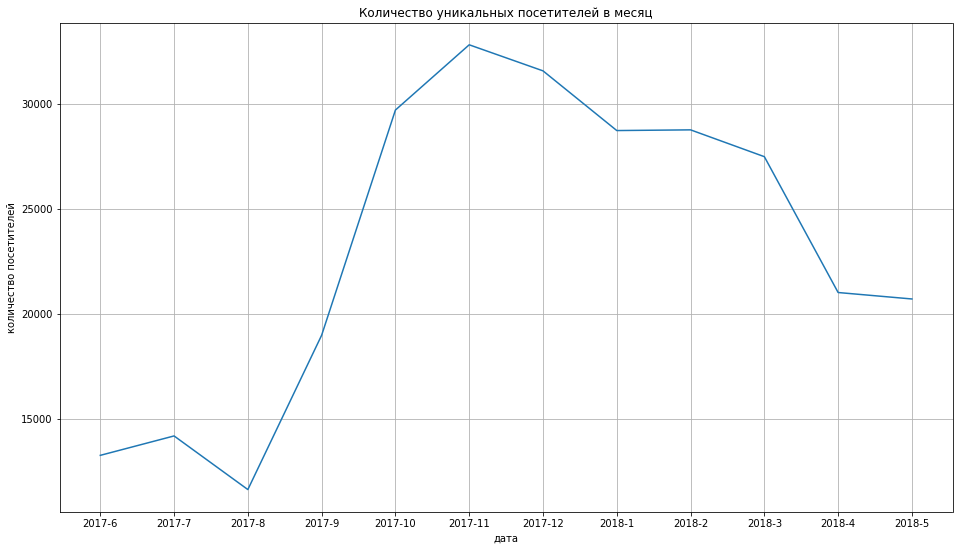

In [37]:
x = ['{1}-{0}'.format(month, year) for month, year in zip(mau['session_month'], mau['session_year'])]
y = mau['uid']
plt.figure(figsize=(16,9))
plt.plot(x, y)
plt.title('Количество уникальных посетителей в месяц')
plt.xlabel('дата')
plt.ylabel('количество посетителей')
plt.grid()
plt.show()

В силу определения метрики ломаная, представляющая собой график MAU, имеет меньше вершин, пики отсутствуют, зато более наглядно виден общий тренд: резкий взлет числа уникальных пользователей в месяц с августа по ноябрь 2017 и дальнейшее снижение с декабря.

**Количество посещений сайта** <a name="visits_num"></a>

Определим, сколько раз за день пользователи в среднем заходят на сайт:

In [38]:
visits_n = visits.groupby('session_date').agg({'uid': 'count'}).reset_index()
print('Среднее число сессий в день =', int(visits_n.mean()))

Среднее число сессий в день = 987


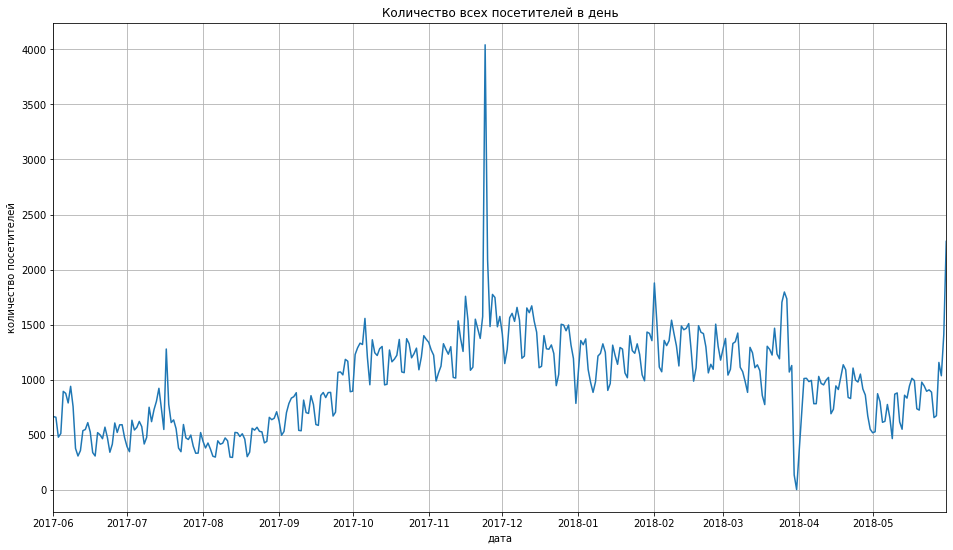

In [39]:
visits_n.plot(x = 'session_date', y = 'uid', grid = True, figsize = (16,9),\
                         title = 'Количество всех посетителей в день', legend = False)
plt.xlabel('дата')
plt.ylabel('количество посетителей')
plt.show()

Среднее число посещений сайта в день больше, чем количество посещений уникальными пользователями (987 против 907). При этом поведение ломаной полностью соответствует характеру графика DAU.

**Количество и средняя продолжительность пользовательских сессий** <a name="sessions"></a>

Определим, сколько времени пользователи проводят на сайте. Сначала посмотрим, сколько сессий в месяц приходилось на одного пользователя - разделим число сессий на число пользователей.

In [40]:
ses_per_user = visits.groupby(['session_year', 'session_month']).agg({'uid': ['count','nunique']})
ses_per_user.columns = ['n_sessions', 'n_users']
ses_per_user['sessions_per_user'] = ses_per_user['n_sessions'] / ses_per_user['n_users']
display(ses_per_user) 

n_sessions  n_users  sessions_per_user
session_year session_month                                        
2017         6                   16505    13259           1.244815
             7                   17828    14183           1.256998
             8                   14355    11631           1.234202
             9                   23907    18975           1.259921
             10                  37903    29692           1.276539
             11                  43969    32797           1.340641
             12                  41983    31557           1.330386
2018         1                   36939    28716           1.286356
             2                   37182    28749           1.293332
             3                   35679    27473           1.298693
             4                   26515    21008           1.262138
             5                   26635    20701           1.286653

Таким образом, в среднем на одного пользователя приходится 1,2-1,3 сессии в месяц.

---
Теперь посчитаем среднюю длительность сессии.

In [41]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print(visits['session_duration_sec'].mean().round(2)) 

643.51


In [42]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

Половина всех сессий длится не более 5 минут.

Посмотрим на распределение полученной величины на гистограмме:

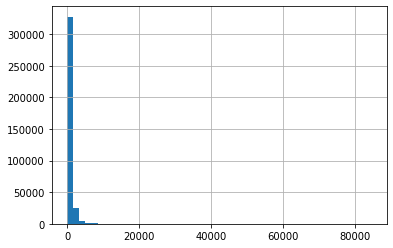

In [43]:
visits['session_duration_sec'].hist(bins=50)
plt.show()

Распределение совсем не похоже на нормальное (основная часть значений сосредоточена в левой части графика), поэтому более корректно будет использовать моду вместо среднего или медианы:

In [44]:
asl = visits['session_duration_sec'].mode()
print(asl)

0    60
dtype: int64


Увеличим масштаб гистограммы, отобразив все значения до 75%-го квартиля:

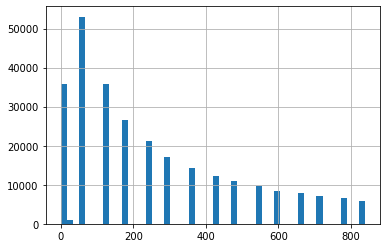

In [45]:
visits['session_duration_sec'].hist(bins = 50, range = (0, np.percentile(visits['session_duration_sec'], 75)))
plt.show()

In [46]:
visits.query('session_duration_sec == 60').shape[0]

53029

In [47]:
visits.query('session_duration_sec < 60').shape[0]

36662

In [48]:
visits.query('session_duration_sec == 0').shape[0]

35794

Средняя продолжительность пользовательской сессии составляет одну минуту. Таких записей 53029 (14,7%). Еще более коротких сессий 36662, причем из них 35794 (10% от общего числа) нулевые. Проверим, на устройствах какого типа это случается чаще:

In [49]:
visits.query('session_duration_sec == 0 & device == "desktop"').shape[0]

23689

23689 (66%) из всех нулевых сессий приходятся на настольные компьютеры. Однако среди всех сессий устройства типа desktop использовались в 73% случаев (262567 из 359400). Поэтому в целом можно предположить, что мобильная версия сайта работает хуже, но разница не столь существенна.

При дальнейшем анализе не будем исключать из датафрейма записи, соответствующие сессиям с нулевой длительностью, поскольку для большинства источников трафика маркетинговые расходы зависят от числа кликов, а не продолжительности сессий.

**Расчет Retention Rate** <a name="ret_rate"></a>

Рассчитаем коэффициент удержания пользователей Retention Rate, используя когортный анализ.

Для построения когорты надо определить событие - это будет дата первой сессии пользователя на сайте - а также период. Будем формировать когорты периодом в 1 месяц. 

Запишем данные о первой сессии на сайте в объект **first_session_date** и объединим его с таблицей **visits**:

In [50]:
first_sess_date = visits.groupby(['uid'])['start_ts'].min()
first_sess_date.name = 'first_sess_date'
visits = visits.join(first_sess_date, on='uid') 

Выделим из столбцов с датами сессий месяцы:

In [51]:
visits['first_sess_month'] = visits['first_sess_date'].astype('datetime64[M]')
visits['sess_month'] = visits['start_ts'].astype('datetime64[M]')

In [52]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_weekday,session_date,session_duration_sec,first_sess_date,first_sess_month,sess_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,0,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,5,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,6,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,2017-12-01


Когортой будет столбец **first_sess_month** — месяц, в котором пользователь впервые зашел на сайт. Рассчитаем lifetime каждого пользователя в рамках когорты:

In [53]:
visits['cohort_lifetime'] = (visits['sess_month'] - visits['first_sess_month']) / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей в каждом месяце:

In [54]:
cohorts_vis = visits.groupby(['first_sess_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

In [55]:
cohorts_vis.head()

,first_sess_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Чтобы рассчитать Retention Rate, определим число пользователей, изначально бывших в когорте, и разделим на него число пользователей в этой же когорте в каждом следующем месяце:

In [56]:
initial_users_count = cohorts_vis[cohorts_vis['cohort_lifetime'] == 0][['first_sess_month','uid']]
initial_users_count = initial_users_count.rename(columns = {'uid':'cohort_users'})

Объединим данные по когортам с исходным количеством пользователей в когорте и рассчитаем Retention Rate:

In [57]:
cohorts_vis = cohorts_vis.merge(initial_users_count, on='first_sess_month')
cohorts_vis['retention'] = cohorts_vis['uid'] / cohorts_vis['cohort_users'] 

In [58]:
cohorts_vis.head()

,first_sess_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


Построим сводную таблицу и на ее основе создадим тепловую карту:

In [59]:
vis_retention_pivot = cohorts_vis.pivot_table(index = 'first_sess_month',\
                                              columns = 'cohort_lifetime',\
                                              values = 'retention', aggfunc = 'sum')
vis_retention_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_sess_month,,,,,,,,,,,,
2017-06-01,1.0,0.0786635,0.0537748,0.0613923,0.0685572,0.0714232,0.0610152,0.0577721,0.0523418,0.0508334,0.0406516,0.0449506
2017-07-01,1.0,0.0560883,0.0512938,0.0561644,0.0582192,0.0481735,0.0453577,0.0457382,0.0388128,0.0286149,0.0274734,
2017-08-01,1.0,0.076908,0.0628622,0.062764,0.0500933,0.0440035,0.0363422,0.0394853,0.0278951,0.0260289,,
2017-09-01,1.0,0.0854885,0.069205,0.0507064,0.0393918,0.0378352,0.0358597,0.0241858,0.0228089,,,
2017-10-01,1.0,0.078608,0.0522385,0.0389575,0.0342611,0.0322208,0.0213651,0.0203642,,,,
2017-11-01,1.0,0.078281,0.0441133,0.0386817,0.0337272,0.0234146,0.0217998,,,,,
2017-12-01,1.0,0.0558018,0.0379927,0.0311065,0.0202628,0.0190359,,,,,,
2018-01-01,1.0,0.0597153,0.0393388,0.0249735,0.020244,,,,,,,
2018-02-01,1.0,0.0570798,0.0254539,0.0200928,,,,,,,,


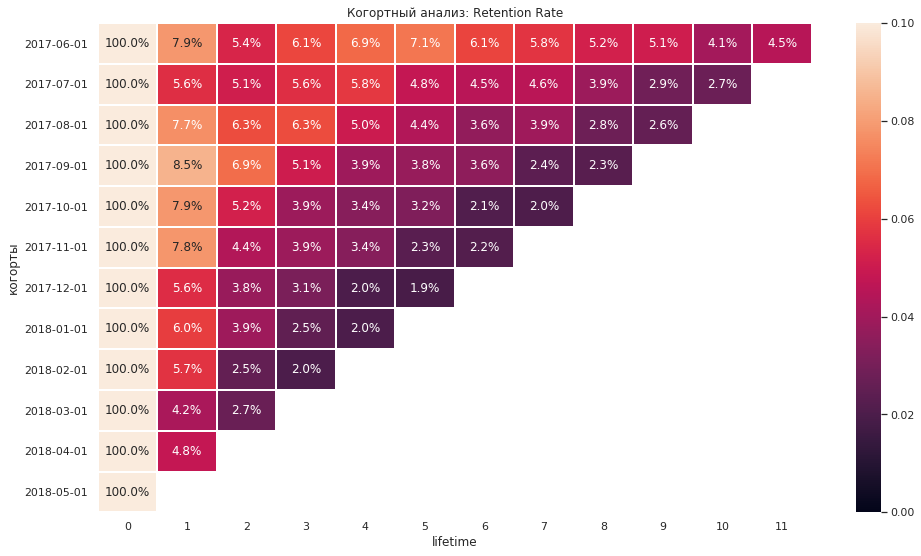

In [60]:
sns.set(style = 'white')
plt.figure(figsize = (16, 9))
plt.title('Когортный анализ: Retention Rate')
ax = sns.heatmap(vis_retention_pivot, annot = True, fmt = '.1%', linewidths = 1, linecolor = 'white',\
                 vmin = 0, vmax = 0.1)
ax.set_yticklabels(vis_retention_pivot.index.date)
plt.xlabel('lifetime')
plt.ylabel('когорты')
plt.show()

На получившейся тепловой карте можно заметить, что число пользователей, ушедших уже в первый месяц, крайне велико - от 91,5% (когорта сентября 2017 г.) до 95,8% (когорта марта 2018 г.). После также наблюдается снижение Retention Rate от месяца к месяцу, но гораздо более плавное. Таким образом, можно сделать вывод, что немногие пользователи покупают билеты на Яндекс.Афише из месяца в месяц, доля постоянных пользователей незначительна (возможно, это связано с тем, что часть людей не имеет возможности или привычки посещать мероприятия даже раз в месяц).

Что касается поведения пользователей в разных когортах, то для каждого значения lifetime показатель Retention Rate снижается от первой когорты к последней, что может говорить об ухудшении качества источников трафика или появлении проблем на сайте. Несмотря на низкие значения в целом, Retention Rate первой когорты значительно превосходит остальные. Возможно, следует рассмотреть, чем профиль пользователей из первой когорты отличается от профилей остальных, чтобы понять, что удерживает их на сайте.

**Вывод**

Количество уникальных пользователей, посещающих сайт Яндекс.Афиши по субботам и воскресеньям, на 20-25% ниже по сравнению с буднями.

Среднее значение числа уникальных пользователей в день - 907, в неделю - 5716, в месяц - 23228.

В целом графики DAU и WAU отражают следующие тренды в рассматриваемом периоде:

- рост числа уникальных посетителей с августа по декабрь 2017 г.;
- примерно одинаковое число уникальных посетителей с января по март 2018 г.;
- падение числа уникальных посетителей с апреля по июнь 2018 г.
    
Графика WAU визуально похож на график DAU, однако на нем отсутствуют локальные пики, соответствующие будням и выходным. Также ломаная выглядит более крутой, поскольку аномальные значения "размазаны". График MAU еще более сглажен, пики отсутствуют, зато более наглядно виден общий тренд: резкое увеличение числа уникальных пользователей в месяц с августа по ноябрь 2017 г. и дальнейшее снижение с декабря.

В среднем на одного пользователя приходится 1,2-1,3 сессии в месяц. Средняя продолжительность пользовательской сессии составляет одну минуту. Таких сессий 14,7% от общего числа. Половина всех сессий короче 5 минут. Нулевых сессий - 10% от общего количества.

66% из всех нулевых сессий приходятся на пользователей с настольными компьютерами. Однако поскольку сессии с устройств типа desktop проводились в 73% случаев, можно предположить, что именно мобильная версия сайта работает хуже. Тем не менее разница не столь существенна.

Число пользователей, прекративших использование сайта в первый месяц, существенно - 91,5-95,8%. Далее Retention Rate продолжает снижаться, однако не так резко. Это означает, что доля постоянных пользователей невысока (возможно, часть людей не имеет возможности или привычки посещать мероприятия даже раз в месяц).

Что касается поведения пользователей в разрезе когорт, то для каждого значения lifetime показатель Retention Rate снижается от первой когорты к последней, что может говорить об ухудшении качества источников трафика или появлении проблем на сайте. Первая когорта выделяется на фоне остальных, и следует сравнить профили пользователей, чтобы найти причину более высокого коэффициента удержания.

### Метрики электронной коммерции <a name="ecom_met"></a>

Рассчитаем основные метрики, отражающие объем покупок клиентов и полученной выручки.

**Среднее время с момента первого посещения сайта до совершения покупки** <a name="time_to_buy"></a>

Отберем из таблиц **visits** и **orders** данные о времени начала первой сессии и первой покупки соответственно, после чего объединим их во вспомогательный датафрейм:

In [61]:
fst_visit = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
fst_order = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()

In [62]:
fst_visit_order = fst_order.merge(fst_visit, on = 'uid')\
                    .rename(columns = {'start_ts':'first_visit_date', 'buy_ts':'first_order_date'})

In [63]:
fst_visit_order.head()

,uid,first_order_date,first_visit_date
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [64]:
fst_visit_order.shape[0]

36523

Найдем искомый временной промежуток для каждого пользователя:

In [65]:
fst_visit_order['time_to_order'] = fst_visit_order['first_order_date'] - fst_visit_order['first_visit_date']

In [66]:
fst_visit_order.head()

,uid,first_order_date,first_visit_date,time_to_order
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106 days 23:02:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0 days 01:19:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0 days 19:44:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00


Чтобы решить, какое из средних выбрать, посмотрим на распределение переменной **time_to_order**, переведя временные отрезки в минуты:

In [67]:
fst_visit_order['time_to_order'].describe()

count                      36523
mean     16 days 21:40:10.550064
std      47 days 01:44:46.481416
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:00
max            363 days 07:04:00
Name: time_to_order, dtype: object

In [68]:
t = fst_visit_order['time_to_order'] / np.timedelta64(1, 'm')

In [69]:
t.describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: time_to_order, dtype: float64

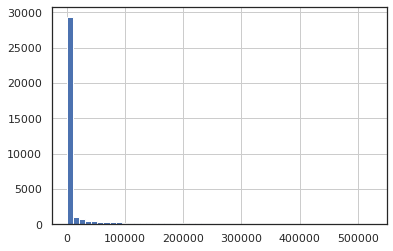

In [70]:
t.hist(bins=50)

Почти все значения сосредоточены в левой части графика. В этом случае в качестве среднего лучше всего выбрать моду:

In [71]:
fst_visit_order['time_to_order'].mode()

0   00:01:00
dtype: timedelta64[ns]

Таким образом, в среднем пользователь делает свою первую покупку на сайте через минуту после первого посещения. Это говорит о том, что большинство клиентов заранее знает, что хочет купить, и целенаправленно заходит на сайт. 25% пользователей хватает четырех минут, другим 25% для первого заказа требуется более двух дней.

**Среднее количество покупок на клиента за полгода** <a name="buy_per_user"></a>

С помощью когортного анализа рассчитаем среднее количество покупок на одного клиента за полгода.

Создадим вспомогательную таблицу с датой первой покупки и объединим ее с таблицей **orders**:

In [72]:
fst_order = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
fst_order = fst_order.rename(columns = {'buy_ts':'first_order_date'})
display(fst_order.head())
fst_order.shape[0]

,uid,first_order_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


36523

In [73]:
display(orders.head())
orders.shape[0]

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


50415

In [74]:
fst_order = orders.merge(fst_order, on = 'uid')
fst_order.shape[0]

50415

Выделим из столбцов с датами первой покупки месяцы:

In [75]:
fst_order['first_ord_month'] = fst_order['first_order_date'].astype('datetime64[M]')
fst_order['ord_month'] = fst_order['buy_ts'].astype('datetime64[M]')
fst_order.head()

,buy_ts,revenue,uid,first_order_date,first_ord_month,ord_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


Когортой будет столбец **first_ord_month** — месяц, в котором пользователь впервые сделал покупку. Посчитаем количество уникальных пользователей в каждой когорте и число покупок в каждой когорте за весь период:

In [76]:
cohorts = fst_order.groupby(['first_ord_month','ord_month'])\
                   .agg({'revenue': 'sum', 'uid': 'nunique', 'buy_ts': 'nunique'}).reset_index()

cohorts.columns = ['first_ord_month', 'ord_month', 'revenue', 'users_unique_n', 'purchase_num']

cohorts['age'] = (cohorts['ord_month'] - cohorts['first_ord_month']) / np.timedelta64(1, 'M')
cohorts['age'] = cohorts['age'].round().astype('int')
cohorts['avg_purchase'] = cohorts['purchase_num'] / cohorts['users_unique_n'] 

avg_purchase_pivot = cohorts.pivot_table(index = 'first_ord_month',\
                                              columns = 'age',\
                                              values = 'avg_purchase', aggfunc = 'mean')
display(avg_purchase_pivot.fillna(''))

age,0,1,2,3,4,5,6,7,8,9,10,11
first_ord_month,,,,,,,,,,,,
2017-06-01,1.109738,2.88525,3.48,4.12963,3.31818,3.23881,4.43548,3.70213,3.65517,3.37778,2.13333,1.62264
2017-07-01,1.079563,1.92308,2.10526,1.60938,1.46939,2.15789,1.66667,1.25641,1.38095,1.09091,2.03846,
2017-08-01,1.081022,1.84483,1.88679,1.81818,2.1,1.9375,1.63333,1.77273,2.42105,1.48387,,
2017-09-01,1.079427,1.68462,1.6,2.21622,1.28846,1.70312,1.63636,1.51351,1.4186,,,
2017-10-01,1.044470,1.51942,1.31707,1.32609,1.3871,1.43056,1.53571,1.86567,,,,
2017-11-01,1.049743,1.75676,1.5,1.98113,1.67901,1.22917,1.64516,,,,,
2017-12-01,1.059092,1.84247,1.96117,1.84536,1.72,1.66667,,,,,,
2018-01-01,1.051290,1.94737,1.91566,1.48837,1.73333,,,,,,,
2018-02-01,1.032320,1.87288,1.43103,1.79487,,,,,,,,


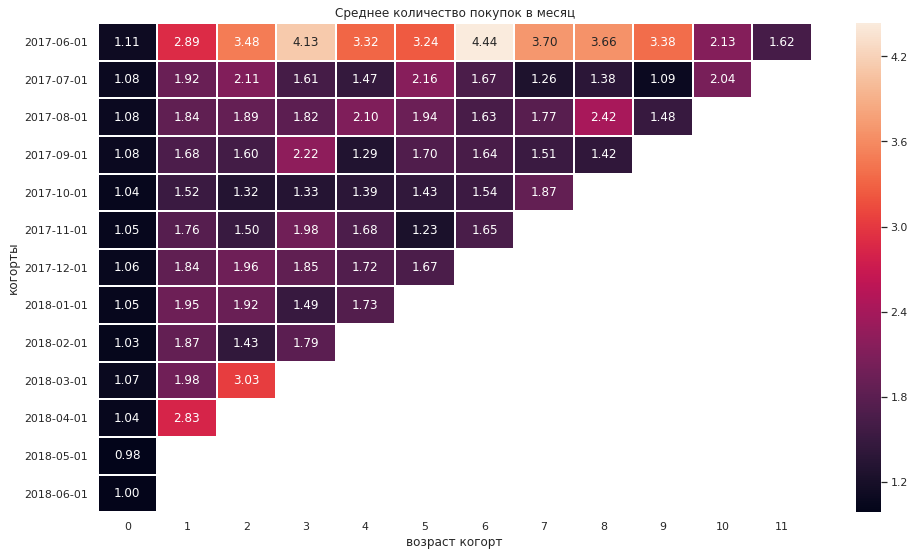

In [77]:
sns.set(style = 'white')
plt.figure(figsize = (16, 9))
plt.title('Среднее количество покупок в месяц')
ax = sns.heatmap(avg_purchase_pivot, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'white')
ax.set_yticklabels(avg_purchase_pivot.index.date)
plt.xlabel('возраст когорт')
plt.ylabel('когорты')
plt.show()

Среднее количество покупок в месяц выше всего у первой когорты - более 3, в то время как во всех остальных когортах оно нигде не превышает 2. Следует также обратить внимание на мартовскую и апрельскую когорты - в них единственных, за исключением первой, в последний месяц существования показатель такой же высокий, как и у лидирующей первой когорты. 

Что касается общей тенденции, в "нулевом" месяце все покупатели совершают в среднем один заказ, в следующем - 1,5-1,9, далее показатель колеблется возле этого значения, тренда на возрастание или убывание нет. 

Теперь можно вычислить среднее число покупок на клиента за полгода. Посчитаем накопительным итогом количество покупок в каждом месяце:

In [78]:
avg_cumsum_purchase_pivot = cohorts.pivot_table(index = 'first_ord_month',\
                                              columns = 'age',\
                                              values = 'purchase_num', aggfunc = 'sum')
avg_cumsum_purchase = avg_cumsum_purchase_pivot.cumsum(axis=1)
avg_cumsum_purchase = avg_cumsum_purchase 
display(avg_cumsum_purchase.fillna(''))

age,0,1,2,3,4,5,6,7,8,9,10,11
first_ord_month,,,,,,,,,,,,
2017-06-01,2245.0,2421,2595,2818,3110,3327,3602,3776,3988,4140,4236,4322
2017-07-01,2076.0,2176,2296,2399,2471,2553,2613,2662,2720,2744,2797,
2017-08-01,1481.0,1588,1688,1768,1852,1914,1963,2041,2087,2133,,
2017-09-01,2786.0,3005,3165,3329,3396,3505,3613,3669,3730,,,
2017-10-01,4533.0,4846,5008,5130,5259,5362,5448,5573,,,,
2017-11-01,4284.0,4674,4854,5064,5200,5259,5361,,,,,
2017-12-01,4642.0,4911,5113,5292,5378,5483,,,,,,
2018-01-01,3546.0,3768,3927,3991,4069,,,,,,,
2018-02-01,3769.0,3990,4073,4143,,,,,,,,


Обратим внимание на то, что начиная с октябрьской когорты, в первом месяце общее число покупок выросло почти вдвое, а затем пошло на спад. Возможно, это связано с проводимой рекламной кампанией.

Чтобы получить среднее значение за 6 прошедших месяцев, разделим накопительное число покупок на количество уникальных клиентов в каждой когорте, время существования которой совпадает с нужным периодом, а затем усредним:

In [79]:
users_unique = cohorts.pivot_table(index = 'first_ord_month', values = 'users_unique_n', aggfunc = 'sum').reset_index()
users_unique

,first_ord_month,users_unique_n
0,2017-06-01,2653
1,2017-07-01,2348
2,2017-08-01,1721
3,2017-09-01,3147
4,2017-10-01,5049
5,2017-11-01,4720
6,2017-12-01,4842
7,2018-01-01,3658
8,2018-02-01,3866
9,2018-03-01,3681


In [80]:
m = avg_cumsum_purchase.reset_index()[5] / users_unique['users_unique_n']
m[:6].mean().round(2)

1.12

Таким образом, в среднем за полгода пользователи делают 1,12 покупки (существенная разница со среднемесячным количеством покупок объясняется тем, что в каждой когорте основная масса заказов и приток новых покупателей приходятся на первый месяц, в последующие месяцы за повторными заказами приходит только небольшая часть когорты - самые лояльные к сервису посетители).

**Средняя выручка с пользователя** <a name="avg_rev"></a>

Средняя выручка сайта за весь пероид существования - это отношение общей выручки к количеству уникальных пользователей. Воспользуемся для подсчета созданной ранее вспомогательной таблицей (**orders** + столбец с датой первой покупки клиента):

In [81]:
fst_order.head()

,buy_ts,revenue,uid,first_order_date,first_ord_month,ord_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [82]:
avg_rev_total = fst_order['revenue'].sum() / fst_order['uid'].nunique()
avg_rev_total.round(2)

6.9

Таким образом, средняя выручка за весь период с пользователей, которые сделали хотя бы один заказ, составялет 6,9 у.е. Теперь рассмотрим, как меняется этот показатель во времени. Посчитаем его как отношение месячной выручки к количеству покупателей, сделавших покупки в этом месяце:

In [83]:
fst_order['first_ord_month'] = fst_order['first_order_date'].astype('datetime64[M]')
fst_order['ord_month'] = fst_order['buy_ts'].astype('datetime64[M]')
fst_order.head()

,buy_ts,revenue,uid,first_order_date,first_ord_month,ord_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [84]:
order_grouped = fst_order.groupby('ord_month').agg({'revenue': 'sum', 'uid': 'nunique'})\
                    .reset_index()\
                    .rename(columns = {'uid':'clients_unique_num'})
order_grouped['avg_month_revenue_client'] = order_grouped['revenue'] / order_grouped['clients_unique_num']
order_grouped

,ord_month,revenue,clients_unique_num,avg_month_revenue_client
0,2017-06-01,9557.49,2023,4.724414
1,2017-07-01,12539.47,1984,6.320297
2,2017-08-01,8758.78,1472,5.950258
3,2017-09-01,18345.51,2750,6.671095
4,2017-10-01,27987.70,4675,5.986674
5,2017-11-01,27069.93,4547,5.953360
6,2017-12-01,36388.60,4942,7.363132
7,2018-01-01,19417.13,3898,4.981306
8,2018-02-01,25560.54,4258,6.002945
9,2018-03-01,28834.59,4181,6.896577


Для налядности отразим изменение среднемесячной выручки с клиента на графике:

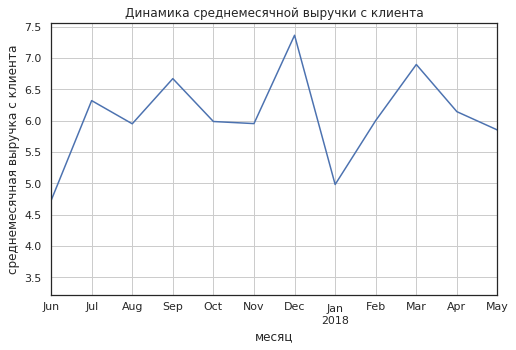

In [85]:
order_grouped.plot(x = 'ord_month', y = 'avg_month_revenue_client', figsize = (8,5),\
                         title = 'Динамика среднемесячной выручки с клиента', legend = False)
plt.xlabel('месяц')
plt.xlim(pd.Timestamp('2017-06-01'), pd.Timestamp('2018-05-01'))
plt.ylabel('среднемесячная выручка с клиента')
plt.grid(True, which='both') 
plt.show()

С графика убрана последняя точка, соответствующая июню 2018 г., поскольку информация имеется только за первый день месяца. Среднемесячная выручка с клиента колеблется в промежутке от 4,7 до 7,4 у.е. В декабре наблюдаем ожидаемый предновогодний пик (возможно, клиенты покупают больше билетов или билеты на более дорогие места в качестве подарков). После январского спада выручка возвращается примерно на допраздничный уровень.

**Динамика LTV** <a name="ltv"></a>

Рассмотрим, как меняется во времени накопительный LTV по когортам, а также сравним средний LTV по когортам за 6 месяцев. По условию маржинальность сервиса — 100%, т.е. вместо показателя валовой прибыли можно использовать выручку.

Воспользуемся таблицей **fst_order**, в которой уже указан месяц первого заказа:

In [86]:
fst_order.head()

,buy_ts,revenue,uid,first_order_date,first_ord_month,ord_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


Посчитаем количество новых покупателей за каждый месяц:

In [87]:
cohort_sizes = fst_order.groupby('first_ord_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_ord_month', 'users_unique_num']
cohort_sizes.head() 

,first_ord_month,users_unique_num
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. 

In [88]:
cohorts = fst_order.groupby(['first_ord_month','ord_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_ord_month,ord_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [89]:
report = pd.merge(cohort_sizes, cohorts, on='first_ord_month')
report.head()

,first_ord_month,users_unique_num,ord_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Добавим столбец в таблицу столбец с возрастом когорты:

In [90]:
report['age'] = (report['ord_month'] - report['first_ord_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_ord_month,users_unique_num,ord_month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


Добавим LTV и выведем сводную таблицу по накопительному LTV:

In [91]:
report['ltv'] = report['revenue'] / report['users_unique_num']
ltv = report.groupby(['first_ord_month','age']).agg({'ltv':'mean'})

In [92]:
ltv = report.pivot_table(index='first_ord_month', columns='age', values='ltv', aggfunc='mean')
ltv_cumsum = ltv.cumsum(axis=1)
ltv_cumsum.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_ord_month,,,,,,,,,,,,
2017-06-01,4.724414,5.20974,5.64738,6.60205,7.62458,8.36008,9.31052,9.89212,10.4453,11.0511,11.6224,11.8792
2017-07-01,6.010218,6.34543,6.96896,7.32794,7.50473,7.66077,7.78098,7.9228,8.08404,8.23118,8.38685,
2017-08-01,5.276518,5.74851,6.20699,6.59827,7.09232,7.37586,7.58653,7.99153,8.28374,8.47172,,
2017-09-01,5.644529,6.76212,7.28305,11.2588,11.6594,12.3065,13.0081,13.2512,13.4352,,,
2017-10-01,5.003733,5.5395,5.73089,5.88803,6.03959,6.15996,6.24477,6.36024,,,,
2017-11-01,5.154683,5.55392,5.75347,6.07842,6.22644,6.28032,6.39524,,,,,
2017-12-01,4.738191,4.99856,5.92366,6.98894,7.30187,7.63991,,,,,,
2018-01-01,4.135636,4.43039,4.73468,4.87745,4.94015,,,,,,,
2018-02-01,4.156987,4.43526,4.51378,4.58792,,,,,,,,


В таблице **ltv_cumsum** вычислен накопительный LTV в разрезе каждой когорты (последняя строка нас не интересует, поскольку в эту когорту попал единственный покупатель). Построим тепловую карту:

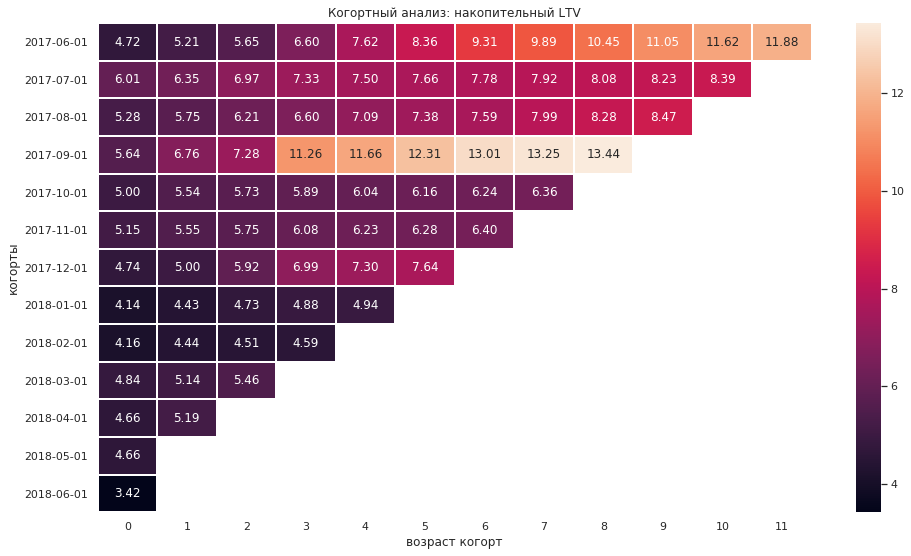

In [93]:
sns.set(style = 'white')
plt.figure(figsize = (16, 9))
plt.title('Когортный анализ: накопительный LTV')
ax = sns.heatmap(ltv_cumsum, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'white')
ax.set_yticklabels(ltv_cumsum.index.date)
plt.xlabel('возраст когорт')
plt.ylabel('когорты')
plt.show()

Среди всех когорт максимальными накопительными LTV выделяются первая и четвертая. Вероятно, в четвертой когорте имел место аномально крупный заказ в третьем месяце, который вызвал рост показателя. Первая когорта - самая привлекательная для бизнеса: у нее максимальный накопительный LTV по каждому возрасту (не считая аномальной сентябрьской когорты), а также, как мы помним, лучший Retention Rate. 

В целом можно отметить, что наблюдается снижение LTV от когорты к когорте, начиная с ноябрьской.

Найдем средний LTV за 6 месяцев (для когорт, "проживших" не менее 6 месяцев, т.е. с первой по седьмую):

In [94]:
avg_ltv_sixm = ltv_cumsum.mean(axis=0)[5]
avg_ltv_sixm.round(2)

7.97

Средний LTV за полгода составляет 7,97.

**Вывод**

Пользователь в среднем (по моде) совершает первую покупку на сайте через минуту после первого посещения. Таким образом, большинство клиентов целенаправленно заходит на сайт, чтобы сделать заранее выбранную покупку. Четверть пользователей совершает первую покупку за четыре первых минуты и менее, другим 25% для первого заказа требуется более двух дней.

В среднем за полгода пользователи делают 1,12 покупки (существенная разница в меньшую сторону со среднемесячным количеством покупок объясняется тем, что в каждой когорте основная масса заказов и приток новых покупателей приходятся на первый месяц, в последующие месяцы за повторными заказами приходят только самые лояльные к сервису посетители).

Среднемесячная выручка с клиента колеблется в промежутке от 4,7 до 7,4 у.е. В декабре наблюдается ожидаемый предпраздничный пик (возможно, клиенты покупают больше билетов или билеты на более дорогие места в качестве подарков). После январского спада выручка возвращается примерно на допраздничный уровень.

Среди всех когорт максимальными накопительными LTV выделяются первая и четвертая (вероятно, в четвертой когорте имел место крупный заказ в третьем месяце, который вызвал рост показателя). Основной прирост накопительного LTV (4,5-6 у.е.) идет в нулевой месяц существования когорт. В целом показатель снижается от когорты к когорте, начиная с пятой.

Средний LTV по когортам за полгода составляет 7,97.

### Маркетинговые метрики <a name="mark_met"></a>

Рассчитаем основные метрики, характеризующие расходы на привлечение покупателей.

**Расходы на маркетинг в динамике и разрезе источников** <a name="mark_costs"></a>

Посчитаем общую сумму расходов на маркетинг. 

In [95]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [96]:
costs['costs'].sum()

329131.62

Общие расходы на маркетинг в рассматриваемом периоде составили 329 131,62 у.е. А выручка всего:

In [97]:
orders['revenue'].sum().round(2)

252057.2

Таким образом, бизнес еще не успел себя окупить. 

Расходы в разрезе источников (мы уже считали их ранее, делая преданализ данных):

In [98]:
costs_per_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()

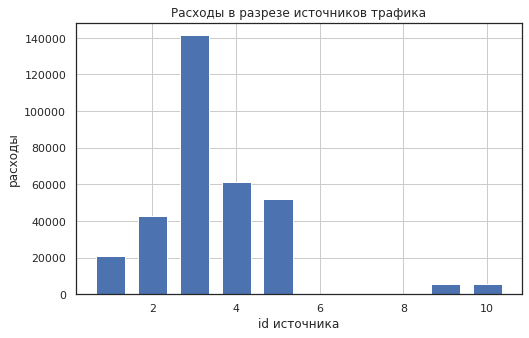

In [99]:
plt.figure(figsize=(8,5))
plt.bar(costs_per_source['source_id'], costs_per_source['costs'], width = 0.7) 
plt.title('Расходы в разрезе источников трафика')
plt.xlabel('id источника')
plt.ylabel('расходы')
plt.grid()
plt.show()

Затраты на источник 3 максимальны и преывшают затраты на следующий за ним источик 4 более чем в 2 раза. На источники 9 и 10 расходы минимальны.

Рассмотрим затраты в динамике:

In [100]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')

In [101]:
costs_per_source_time = costs.groupby(['source_id', 'dt_month']).agg({'costs':'sum'})
costs_per_source_time = costs_per_source_time.pivot_table(index = 'dt_month',\
                                              columns = 'source_id',\
                                              values = 'costs', aggfunc = 'sum')

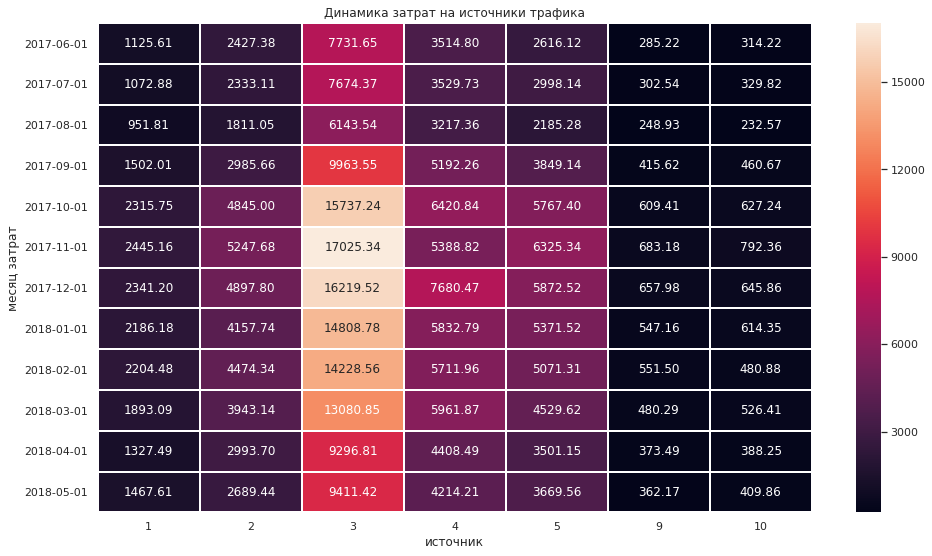

In [102]:
sns.set(style = 'white')
plt.figure(figsize = (16, 9))
plt.title('Динамика затрат на источники трафика')
ax = sns.heatmap(costs_per_source_time, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'white')
ax.set_yticklabels(costs_per_source_time.index.date)
plt.xlabel('источник')
plt.ylabel('месяц затрат')
plt.show()

На тепловой карте выделяются высокие расходы на источник 3, особенно в период с октября по декабрь 2017. На источники 9 и 10 расходы существенно ниже. Видно, что с затраты на каждый из источников увеличивались с начала периода и до ноября (исключение - август), после чего стали снижаться и вернулись примерно к уровню сентября.

**Стоимость привлечения покупателя. CAC** <a name="cac"></a>

Расчитаем, в какую сумму компании обходится привлечение одного покупателя. Общий показатель составит:

In [103]:
cac_total = costs['costs'].sum() / orders['uid'].nunique()
cac_total.round(2)

9.01

Таким образом, для компании привлечение одного пользователя стоит 9,01 у.е. 

Посчитаем САС в разрезе источников трафика. Будем считать под источником привлечения тот источник, с которого пользователь впервые попал на сайт.

У нас уже есть таблица с разбивкой по затратам на каждый источник:

In [104]:
costs_per_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Выберем из таблицы **visits** только первые посещения, чтобы определить источник покупателей:

In [105]:
visits_start = visits.query('start_ts == first_sess_date')

Вычислим количество покупателей, пришедших с того или иного источника:

In [106]:
cients_per_source = (orders.merge(visits_start, on='uid', how='inner')).groupby('source_id').agg({'uid':'nunique'})\
                                                            .reset_index().rename(columns = {'uid':'clients_num'})
cients_per_source

,source_id,clients_num
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


Объединим таблицы и рассчитаем САС:

In [107]:
cac_per_source = cients_per_source.merge(costs_per_source, on = 'source_id', how='outer')
cac_per_source

,source_id,clients_num,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10296,61073.60
4,5,6931,51757.10
5,7,1,NaN
6,9,1088,5517.49
7,10,1329,5822.49


In [108]:
cac_per_source['cac'] = cac_per_source['costs'] / cac_per_source['clients_num']
cac_per_source

,source_id,clients_num,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,7,1,NaN,NaN
6,9,1088,5517.49,5.071222
7,10,1329,5822.49,4.381106


Как видно, самые большие расходы в разрезе источников приходятся на 2 и 3. Лидеры по низким затратам - 4, 9, 10.

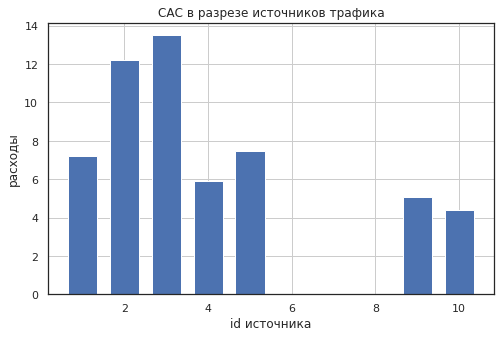

In [109]:
plt.figure(figsize=(8,5))
plt.bar(cac_per_source['source_id'], cac_per_source['cac'], width = 0.7) 
plt.title('CAC в разрезе источников трафика')
plt.xlabel('id источника')
plt.ylabel('расходы')
plt.grid()
plt.show()

**Окупаемость в разрезе источников. ROMI** <a name="romi"></a>

Рассчитаем ROMI по когортам. Построим функцию, которая принимает на вход три датафрейма с записями о посещениях сайта, покупках и затратах на привлечение покупателей, а также метрику, которую нужно рассчитать.

In [110]:
def metrics(df_visits, df_orders, df_costs, met):
# met: 1 - LTV, 2 - накопительный LTV, 3 - ROMI, 4 - накопительный ROMI    
    
# в качестве df_visits при вызове в дальнейшем будем использовать разные срезы данных,   
# поэтому df_visits нужна только для определения условия, каких пользователей отбирать для анализа: 
# например, по источнику трафика и/или типу устройства
    
    fst_sess = df_visits.query('start_ts == first_sess_date')
    
    df_orders_new = df_orders.query('uid in @fst_sess.uid')      
    df_costs_new = df_costs.query('source_id in @df_visits.source_id') 
       
# алгоритм функции аналогичен тому, что использовался при расчете LTV
# дополнительно добавлен расчет САС по когортам, а также ROMI как отношение LTV к CАС
# функция рассчитывает LTV, накопительный LTV, ROMI, накопительный ROMI 

    fst_order = df_orders_new.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
    fst_order = fst_order.rename(columns = {'buy_ts':'first_order_date'})
    
    fst_order = df_orders_new.merge(fst_order, on = 'uid')
    
    fst_order['first_ord_month'] = fst_order['first_order_date'].astype('datetime64[M]')
    fst_order['ord_month'] = fst_order['buy_ts'].astype('datetime64[M]')
    
    cohort_sizes = fst_order.groupby('first_ord_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_ord_month', 'users_unique_n']
    
    cohorts = fst_order.groupby(['first_ord_month','ord_month']).agg({'revenue': 'sum'}).reset_index()
    
    report = pd.merge(cohort_sizes, cohorts, on='first_ord_month')
      
    report['age'] = (report['ord_month'] - report['first_ord_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    
    report['ltv'] = report['revenue'] / report['users_unique_n']
    ltv = report.groupby(['first_ord_month','age']).agg({'ltv':'mean'})

    ltv = report.pivot_table(index='first_ord_month', columns='age', values='ltv', aggfunc='mean')
    ltv_cumsum = ltv.cumsum(axis=1).round(6)  

    monthly_costs = df_costs_new.groupby('dt_month').sum()
    report_new = pd.merge(report, monthly_costs, left_on='first_ord_month', right_on='dt_month')
    report_new['cac'] = report_new['costs'] / report_new['users_unique_n']
    report_new['romi'] = report_new['ltv'] / report_new['cac']
    
    romi = report_new.pivot_table(index='first_ord_month', columns='age', values='romi', aggfunc='mean')
    romi_cumsum = romi.cumsum(axis=1).round(6)
    
    if met == 1:
        table = ltv
        heading = 'Когортный анализ: LTV'
    elif met == 2:
        table = ltv_cumsum
        heading = 'Когортный анализ: накопительный LTV'   
    elif met == 3:
        table = romi
        heading = 'Когортный анализ: ROMI'
    elif met == 4:
        table = romi_cumsum
        heading = 'Когортный анализ: накопительный ROMI'       
    
    try:
        sns.set(style = 'white')
        plt.figure(figsize = (16, 9))
        plt.title(heading)
        ax = sns.heatmap(table, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'white')
        ax.set_yticklabels(table.index.date)
        plt.xlabel('возраст когорт')
        plt.ylabel('когорты')
        plt.show()
    except:
        print('Проверьте параметры')
    

С помощью накопительного ROMI можно определить, как быстро окупается та или иная когорта. Так, сначала посмотрим на исходные данные:

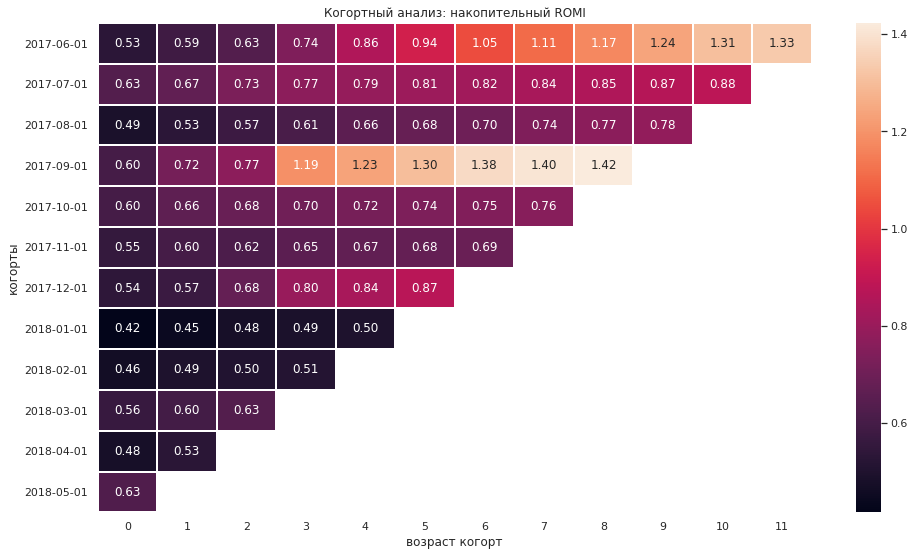

In [111]:
metrics(visits, orders, costs, 4)

Июньская когорта окупилась в шестом месяце, сентябрьская - в третьем, все остальные еще не успели (как мы помним, общие расходы на бизнес пока превышают выручку, поэтому результат не удивителен). Вообще говоря, на графике видно, что с течением времени рост ROMI замедляется, поскольку основная выручка приходится на заказ, совершенный в первые месяцы. Задачей маркетологов должен быть вывод клиентов на более быструю окупаемость.

Рассмотрим ROMI в разрезе различных источников трафика.

Источник 1


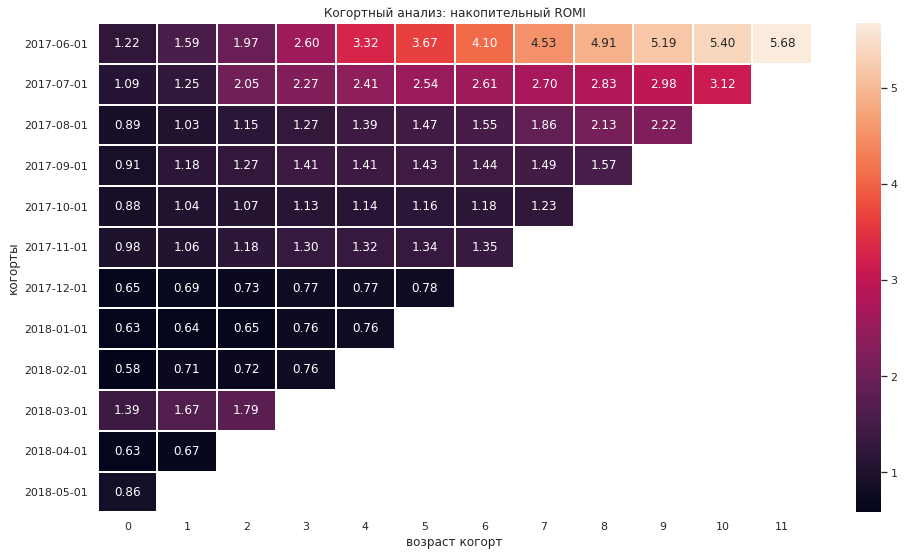

Источник 2


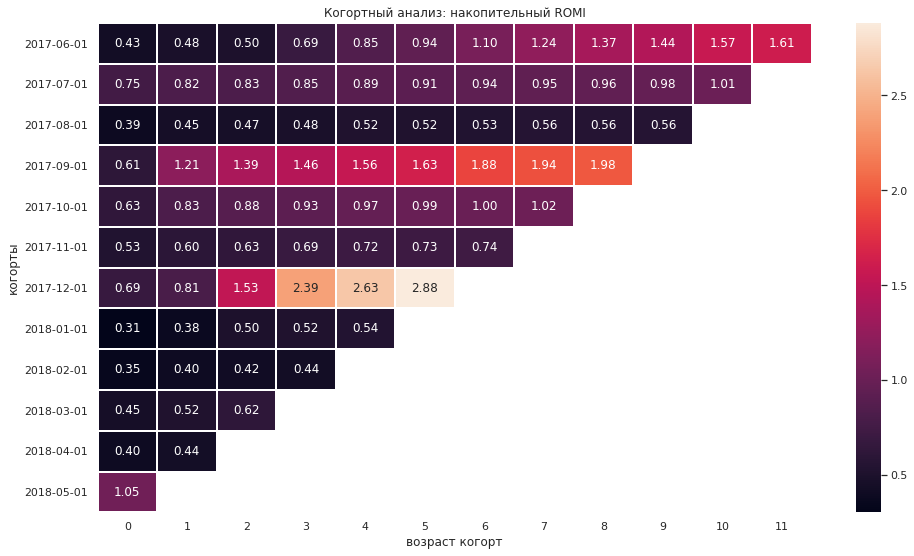

Источник 3


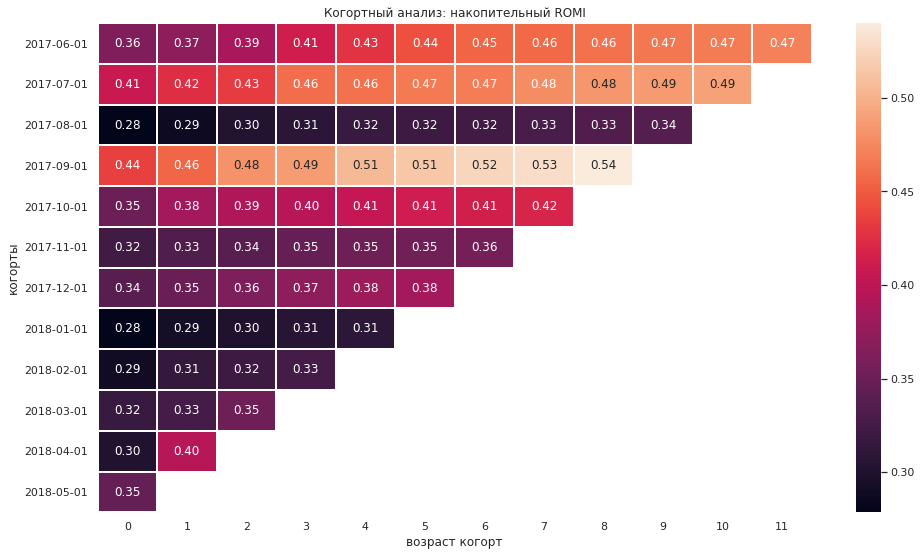

Источник 4


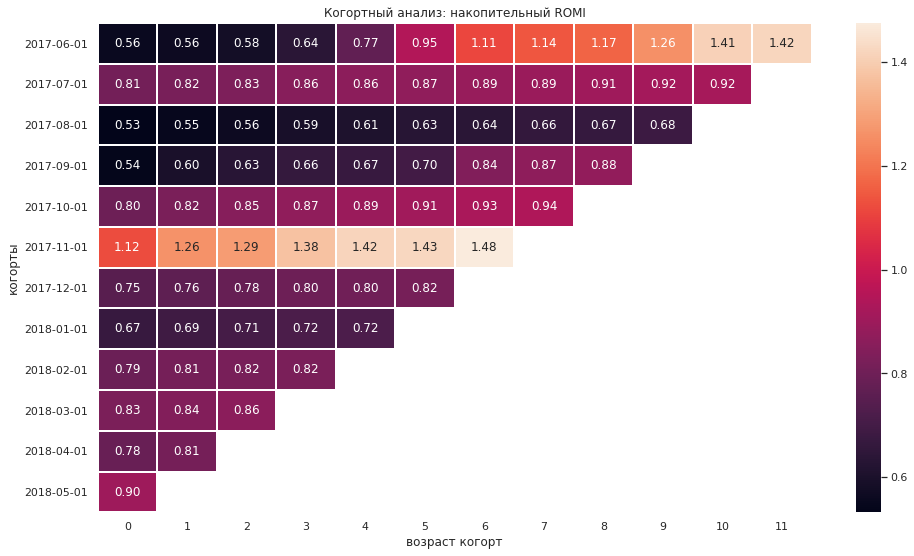

Источник 5


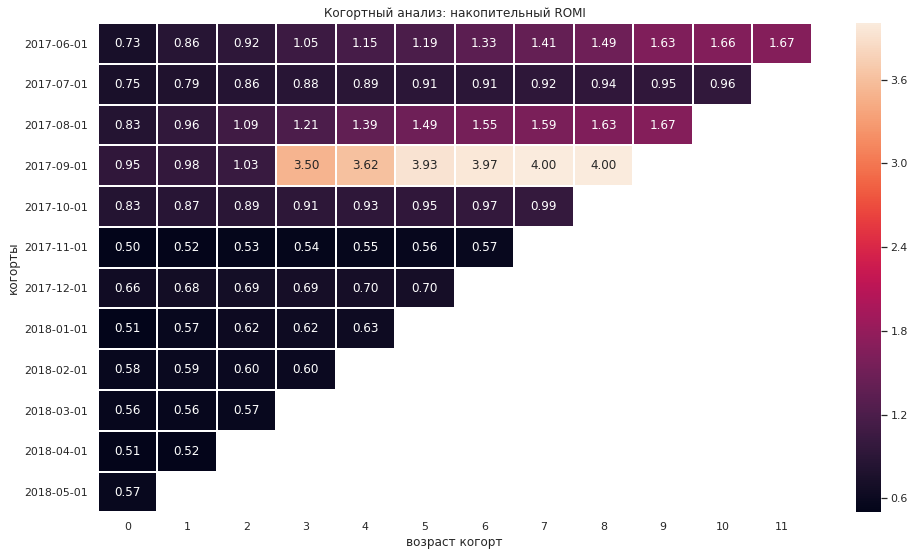

Источник 9


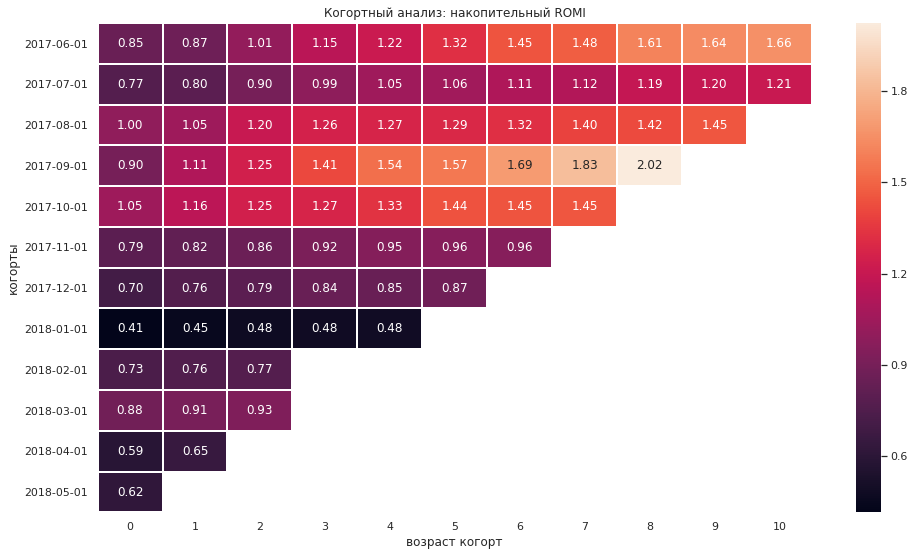

Источник 10


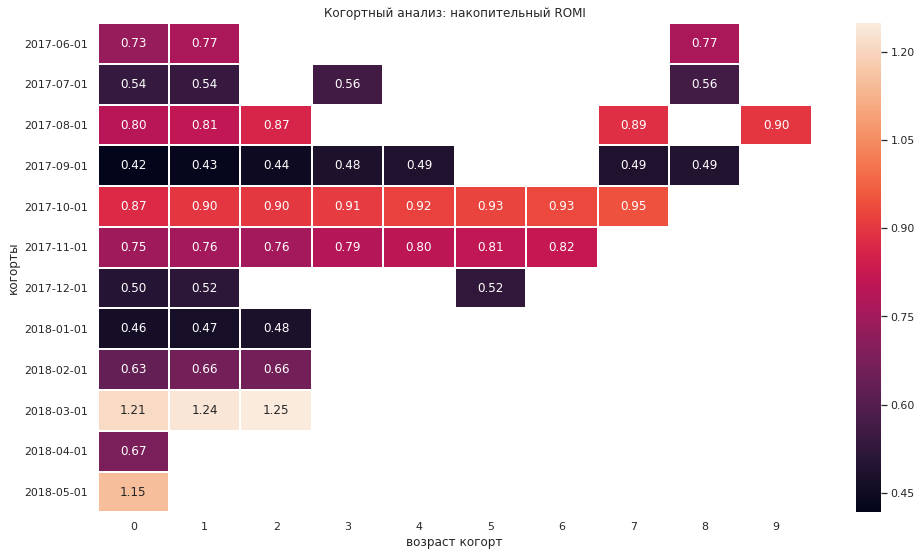

In [112]:
for i in costs['source_id'].unique():
    print('Источник', i)
    metrics(visits.loc[visits['source_id'] == i], orders, costs, 4)

Источник 1 показал лучшие результаты по окупаемости для первой половины когорт: в них ROMI превысил единицу уже на второй месяц. Первая и вторая когорты показали себя лучше остальных. Проблемы начались с декабрьской когорты, когда закончилась рекламная кампания, на окупаемость вышла только мартовская когорта. Тем не менее стоит отметить, что по сравнению с остальными (за исключением 9 и 10), затраты на источник 1 самые низкие. Это явный лидер. 

Нельзя сказать, что источник 2 достаточно себя окупает: есть успешные когорты, есть неудачные. Явные лидеры - июньская, сентябрьская и декабрьская. При этом САС по второму каналу один из самых высоких. Результаты неоднозначны, поэтому этот канал требует дополнительного исследования. 

Источник 3 совершенно неэффективен, работает в убыток. Затраты не окупились даже вполовину. Как мы помним, на него тратится больше всего средств из маркетингового бюджета.

Источник 4 скорее неэффективен - окупились только июньская и ноябрьская когорты - хотя и не настолько плох по сравнению с третьим. У июльской и октябрьской когорт есть шанс выйти в безубыточность. В целом каждая новая когорта 2018 г. показывает все более хорошие результаты.

По источнику 5 окупились июньская, августовская и сентябрьская когорты. Близки к этому июльская и октябрьская. Начиная с ноября окупаемость стала снижаться. Это коррелирует со снижением затрат на источник. В целом с источником можно было бы работать, если бы удалось выяснить, в чем причина резкого падения окупаемости для когорт с ноября, и устранить ее.

Затраты на источник 9 существенно ниже по сравнению с остальными, при этом все когорты, за исключением январской, демонстрируют позитивный тренд по окупаемости. Не все когорты успели окупиться, однако должны выйти в прибыль.

По источнику 10 отсутствует информация о части когорт в определенные месяцы их существования. В любом случае, канал выглядит плохо с точки зрения окупаемости. Возможно, в перспективе окупится октябрьская когорта.

Резюмируя, можно сказать, что маркетологам стоит сделать акцент на источниках 1 и 9. Неоднозначно выглядят источники 2 и 5 - требуется более детальное исследование. Точно следует отказаться от источников 3, 4, 10.

Что касается перспективных когорт - это июньская, июльская, сентябрьская, а также ноябрьская в разрезе источника 4 и мартовская в разрезе источника 1.

**Вывод** 

Максимальные расходы бизнес несет на источнике 3 (суммарно 140 000 у.е.). Они преывшают затраты на следующий за ним источик 4 (60 000 у.е.) более чем в 2 раза. Меньше всего тратится на источники 9 и 10 (менее 5 000 у.е.).

В динамике видим, что с начала рассматриваемого периода и до ноября (исключение - август) увеличивались затраты на все источники, причем сильнее всего на 3, чуть менее интенсивно - на 2, 4 и 5. С декабря расходы стали снижаться и впоследствии вернулись примерно к уровню сентября.

Привлечение одного пользователя обходится компании в среднем в 9,01 у.е. Самые большие расходы на привлечение в разрезе источников приходятся на 2 и 3. Лидеры по низким затратам - 4, 9, 10.

В целом бизнес не успел себя окупить. Общие расходы за период составили 329 131 у.е, а выручка - 252 057 у.е. Лучшими по окупаемости выглядят источники 1 и 9. Неоднозначная картина по источникам 2 и 5 - требуется более детальное исследование. Точно следует что-то менять при работе с источниками 3, 4, 10 либо вообще отказаться от них.

Июньская когорта окупилась в шестом месяце, сентябрьская - в третьем, все остальные еще не успели (как мы помним, общие расходы на бизнес пока превышают выручку, поэтому результат не удивителен). Вообще говоря, на графике видно, что с течением времени рост ROMI замедляется, поскольку основная выручка приходится на заказ, совершенный в первые месяцы. Задачей маркетологов должен быть вывод клиентов на более быструю окупаемость.

В целом перспективными когортами кажутся июньская, июльская, сентябрьская, а также ноябрьская в разрезе источника 4 и мартовская в разрезе источника 1.

## **Анализ в разрезе типов устройств** <a name="device"></a>

Посмотрим на некоторые метрики в разрезе типа устройств пользователя - desktop или touch.

In [113]:
print('С настольных компьютеров на сайт заходит', visits.query('device == "desktop"').shape[0], 'пользователей')
print('С мобильных устройств/планшетов на сайт заходит', visits.query('device == "touch"').shape[0], 'пользователей')

С настольных компьютеров на сайт заходит 262567 пользователей
С мобильных устройств/планшетов на сайт заходит 96833 пользователей


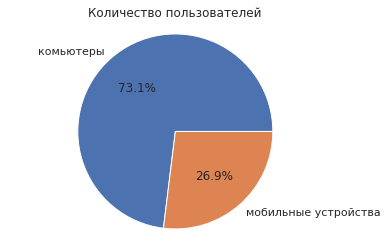

In [114]:
data = [visits.query('device == "desktop"').shape[0], visits.query('device == "touch"').shape[0]]
labels = 'комьютеры', 'мобильные устройства'
plt.pie(data, labels=labels,autopct='%1.1f%%')
plt.title('Количество пользователей')
plt.axis('equal')
plt.show()

Таким образом, мобильными устройствами пользуется около 27% всех пользователей, что кажется крайне малым показателем, исходя из их распространенности. Возможно, есть проблемы с мобильной версией сайта, она неудобна. Необходимо исследовать причины.

Посмотрим на метрику DAU в динамике:

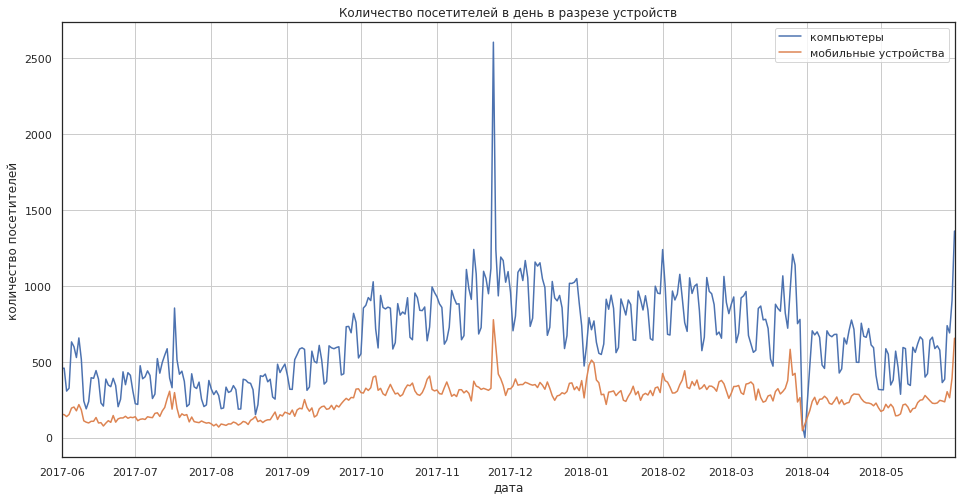

In [115]:
dau_desk = visits.query('device == "desktop"').groupby('session_date').agg({'uid': 'nunique'}).reset_index()
dau_touch = visits.query('device == "touch"').groupby('session_date').agg({'uid': 'nunique'}).reset_index()
ax = dau_desk.plot(x = 'session_date', y = 'uid')
dau_touch.plot(x = 'session_date', y = 'uid', grid = True, figsize = (16,8), ax = ax)
plt.title('Количество посетителей в день в разрезе устройств')
ax.legend(["компьютеры", "мобильные устройства"])
plt.xlabel('дата')
plt.ylabel('количество посетителей')
plt.show()

На графике видна разница (более чем вдвое) между количеством уникальных пользователей в день, заходящих с компьютеров и с мобильных устройств. В промежутке, соответствующему большим затратам на маркетинг (октябрь-январь), виден рост обоих показателей, но кривая desktop поднимается под более крутым углом, разница увеличивается. В правой части графика обе кривые идут на спад, но desktop опять более круто, расстояние между ними уменьшается.

Для пользователей мобильных устройств локальные пики, соответствующие будням и выходным, заметны гораздо меньше. В остальном характер обеих ломаных очень похож.

Сравнивать ROMI в разрезе типов устройств будет не совсем корректно, так как в исходной таблице **costs** есть разбивка по затратам только на каждый источник, а взаимосвязь с устройством установить проблематично. Поэтому ограничимся сравнением выручек:

In [116]:
rev_device = orders.merge(visits_start, on = 'uid', how = 'inner')\
                                .groupby(['source_id', 'device']).agg({'revenue':'sum'})
rev_device = rev_device.reset_index()

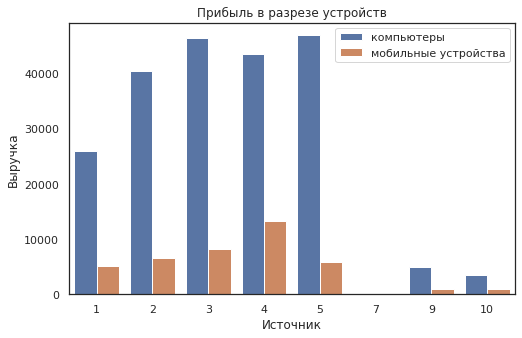

In [117]:
plt.figure(figsize = (8, 5))
labels=["компьютеры","мобильные устройства"]
ax = sns.barplot(x = "source_id", y = "revenue", hue = "device", data = rev_device)
plt.title('Прибыль в разрезе устройств')
ax.set_xlabel('Источник')
ax.set_ylabel('Выручка')
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels)
plt.show()

Существенная разница в посещаемости сайта с устройств разного типа приводит к тому, что в целом выручка с пользователей, пользующихся компьютерами, в несколько раз выше по сравнению с выручкой с пользователей мобильных устройств. 

Интересен источник 4: он заметно лидирует в выручке по мобильным устройствам, притом что относительно компьютеров это не так - для них максимальную выручку приносят источники 3 и 5.

**Вывод** 

Мобильными устройствами пользуется примерно 27% от общего числа пользователей. Это очень мало, учитывая их повсеместную распространенность. Вероятно, есть проблемы и неудобства с мобильной версией сайта. 

Существенная разница в посещаемости сайта с устройств разного типа приводит к тому, что в целом выручка с пользователей, пользующихся компьютерами, в несколько раз выше по сравнению с выручкой с пользователей мобильных устройств.

Маркетологам следует обратить внимание на источник 4, который генерирует самую большую выручку для пользователей мобильных устройств в разрезе источников, Для пользователей, использующих настольные компьютеры, максимальную выручку приносят источники 3 и 5.

## Шаг 3. Выводы и рекомендации <a name="conclusion"></a>

**3.1. Определите источники трафика и тип устройств, на которые маркетологам стоит делать упор. Объясните свой выбор: на какие метрики вы ориентируетесь и почему**

При выборе источника надежнее всего ориентироваться на показатель ROMI, характеризующий окупаемость. Полагаясь только на LTV, мы игнорируем затраты, которые могут превысить доход (как в случае с источником 3, генерирующим максимальный убыток). Напротив, высокие затраты сами по себе не означают, что источник невыгоден, необходимо соизмерить их с показателем выручки (или в общем случае - валовой прибыли). Подводя итог сравнения источников по ROMI, можно сделать следующие выводы:

- фаворит - источник 1: половина когорт окупилась уже на второй месяц, при этом затраты на него самые низкие;
- следует развивать источник 9: все когорты, кроме январской, демонстрируют позитивный тренд по накопительному ROMI. Не все когорты успели окупиться, однако должны выйти в прибыль;
- с оговорками можно продолжать работу с источниками 2 и 5. По пятому источнику следует выяснить причину резкого падения окупаемости для когорт с ноября, и устранить ее. Второй источник генерирует неплохую выручку, но затраты на него тоже велики. Если удастся снизить затраты без существенной потери доходности, стоит использовать его и дальше.
- совершенно неэффективны источники 3, 10 и в меньшей мере 4. От третьего и десятого следует отказаться вообще (по третьему еще и самые большие абсолютные затраты). За четвертым стоит понаблюдать некоторое время, поскольку в последних когортах окупаемость начала расти.
    
Что касается типа устройств, необходимо определить, чем вызвана низкая посещаемость сайта со смартфонов и планшетов. Учитывая, что в современном мире почти все можно сделать с помощью смартфона, компания, вероятно, несет существенные убытки, теряя этот рынок. Нужно проверить корректную работу мобильной версии сайта, а также наличие функционирующего приложения в App Store и Google Store (если они подразумеваются). В рамках дальнейшего развития на рынке смартфонов следует обратить внимание на источник 4, так как он приносит максимальную выручку среди всх источников.

**3.2. Опишите выводы, которые вы сделали после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции**

*Продуктовые метрики*

Среднее значение числа уникальных пользователей в день - 907, в неделю - 5716, в месяц - 23228. Чаще сайт Яндекс.Афиши посещают в будние дни.

Графики DAU и WAU отражают следующие тренды в рассматриваемом периоде:

- рост числа уникальных посетителей с августа по декабрь 2017 г.;
- примерно одинаковое число уникальных посетителей с января по март 2018 г.;
- падение числа уникальных посетителей с апреля по июнь 2018 г.
    
В среднем на одного пользователя приходится 1,2-1,3 сессии в месяц. Средняя продолжительность пользовательской сессии составляет одну минуту. Таких сессий 14,7% от общего числа. Половина всех сессий короче 5 минут. Нулевых сессий - 10% от общего количества. Это очень мало, и одной из задач должно стать удержание пользователей на сайте, чтобы тот как минимум не вызывал желания закрыть его через минуту.

Число пользователей, прекративших использование сайта в первый месяц, существенно - 91,5-95,8%. Фактически большинство клиентов не возвращается за повторными покупками. Далее Retention Rate продолжает снижаться, пусть и менее резко. Поэтому еще одна задача - превратить одноразовых клиентов в постоянных.

*Метрики электронной коммерции*

Пользователь в среднем (по моде) совершает первую покупку на сайте через минуту после первого посещения. Большинство клиентов целенаправленно заходит на сайт, чтобы сделать заранее выбранную покупку. Четверть пользователей совершает первую покупку за четыре минуты и менее, другим 25% для первого заказа требуется более двух дней. 

В среднем за полгода пользователь совершает 1,12 покупки (существенная разница в меньшую сторону со среднемесячным количеством покупок объясняется тем, что в каждой когорте основная масса заказов и приток новых покупателей приходятся на первый месяц, в последующие месяцы за повторными заказами приходят только немного самых лояльных к сервису посетителей). Очередной задачей для бизнеса могло бы стать увеличение числа позиций в чеке клиента.

Среднемесячная выручка с клиента колеблется в промежутке от 4,7 до 7,4 у.е, нет тренда ни на рост, ни на понижение. В декабре наблюдается ожидаемый предпраздничный пик. После январского спада выручка возвращается примерно на допраздничный уровень. При этом для более поздних когорт накопительный LTV меньше, чем для первых. Это сигнализирует об уменьшении выручки с новых покупателей. Возможно, следует менять подход к ценообразованию. Основной прирост накопительного LTV (4,5-6 у.е.) идет в нулевой месяц существования когорт. В целом показатель снижается от когорты к когорте, начиная с пятой.

Средний LTV по когортам за полгода составляет 7,97.

*Маркетинговые метрики*

Бизнес еще не окупил себя. Общие расходы за период составили 329 131 у.е, а выручка - 252 057 у.е.

Максимальные расходы компания несет на источнике 3 (суммарно 140 000 у.е.). Они преывшают затраты на следующий за ним источик 4 (60 000 у.е.) более чем в 2 раза. Меньше всего тратится на источники 9 и 10 (менее 5 000 у.е.).  

В динамике видим, что с начала рассматриваемого периода и до ноября (исключение - август) проводилась рекламная кампания: увеличивались затраты на все источники (сильнее всего на 3, чуть менее интенсивно - на 2, 4 и 5). С декабря расходы стали снижаться и затем вернулись примерно к уровню сентября.

Привлечение одного пользователя обходится компании в среднем в 9,01 у.е. Самые большие расходы на привлечение в разрезе источников приходятся на 2 и 3. Лидеры по низким затратам - 4, 9, 10.

С течением времени рост ROMI замедляется, поскольку основная выручка приходится на заказ, совершенный в первые месяцы. Задачей маркетологов должен быть вывод клиентов на более быструю окупаемость.

Лучшими по окупаемости выглядят источники 1 и 9. Точно следует что-то менять при работе с источниками 3, 4, 10 либо вообще отказаться от них.

**3.3. Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов**

В ходе когортного анализа разных метрик несколько когорт выделяется из общей массы.

Так, например, Retention Rate снижается от первой когорты к последней, причем первая когорта выглядит существенно лучше на фоне остальных. Следует сравнить профили пользователей, чтобы найти причину более высокого коэффициента удержания.

Среднее количество покупок в месяц снова выше всего у первой когорты - более 3, в то время как во всех остальных когортах оно нигде не превышает 2. В части этого показателя следует также обратить внимание на мартовскую и апрельскую когорты - в них единственных, помимо первой, в последний месяц существования показатель такой же высокий, как и у лидирующей первой когорты.

Среди всех когорт максимальными накопительными LTV выделяются первая и четвертая (в четвертой когорте имел место аномально крупный заказ в третьем месяце, который вызвал общий рост показателя). 

По ROMI первая когорта окупилась в шестом месяце, четвертая - в третьем, все остальные еще не успели (как мы помним, общие расходы на бизнес превышают выручку).

В целом перспективными для работы когортами кажутся первая (июньская), вторая (июльская), четвертая (сентябрьская), а также ноябрьская в разрезе источника 4 и мартовская в разрезе источника 1. В целом можно сделать вывод, что последние когорты выглядят по всем параметрам хуже первых, что подтверждает необходимость срочных перемен в бизнесе.

**3.4. Опишите, как различаются метрики в разрезе устройств**

Мобильными устройствами пользуется примерно 27% от общего числа пользователей. Это очень мало, учитывая их повсеместную распространенность. Как было сказано выше, следует проверить корректную работу мобильной версии сайта, а также наличие функционирующего приложения в App Store и Google Store (если они подразумеваются). 

Существенная разница в посещаемости сайта с устройств разного типа приводит к тому, что в целом выручка с пользователей, пользующихся компьютерами, в несколько раз выше по сравнению с выручкой с пользователей мобильных устройств. Бизнес теряет значительную долю рынка.

Источник 4 генерирует самую большую выручку для пользователей мобильных устройств в разрезе источников, Для пользователей, использующих настольные компьютеры, максимальную выручку приносят источники 3 и 5.